In [1]:
import vcf
import vcf.utils
import pandas
import os
import pandas as pd
import itertools
from itertools import groupby
from numpy import *
import operator
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
from scipy.special import logit
import datetime as DT

DAta Diamension and checking for null or NAN values

In [2]:
TA_log=pd.read_csv('TA_analysis.csv',sep=',',header=0,error_bad_lines = False)
TA_log['ts'] = pd.to_datetime(TA_log['ts'], errors='coerce')
print("Number of rows: ", TA_log.shape[0])

print("Number of rows with null: ",TA_log[TA_log.isnull().any(axis=1)].shape[0])


Number of rows:  669491
Number of rows with null:  18


Changing the Timestamp here for each user with date Week Business hours and Weekend

In [4]:

from datetime import datetime
import datetime
TA_log['day_of_week'] =TA_log['ts'].dt.weekday_name
TA_log['date'] = TA_log.ts.dt.floor('d')
TA_log['Busi_days'] = TA_log['ts'].dt.dayofweek < 5
TA_log['Busi_hours'] = TA_log['ts'].dt.time.between(datetime.time(9), datetime.time(18))

Adding the days for the days of week  values

In [7]:
days=["Monday","Tuesday","Wednesday","Thursday","Friday"]

In [8]:
TA_log['DAYS']=np.where(TA_log['day_of_week'].isin(days), 'Busniess_weekday','Weekend')

Distribution of usersacross the month in between the Weekends and Weekdays

/home/alva/Tools/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:15: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
/home/alva/Tools/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


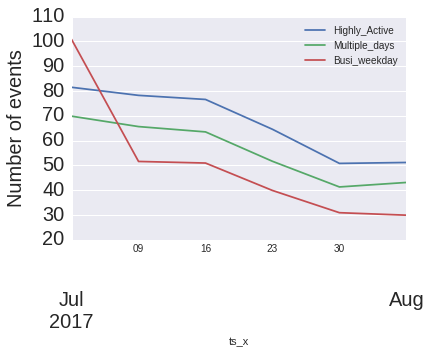

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.set_ylabel('Number of events', fontsize = 20.0)
plt.xticks(size = 20)
plt.yticks(size = 20)
import seaborn as sns

sns.set(rc={'figure.figsize':(15,5)})
for TA in New_melt_new_annon.Activity.unique():
    TA_df = New_melt_new_annon.loc[New_melt_new_annon.Activity == TA]
    TA_df.index = TA_df['ts_x']
    TA_df = TA_df.resample('1W')
    TA_df.plot(x=TA_df.index,
                     y='ts_y', 
                     ax=ax,
                     label=TA)
    

In [9]:
Counts=TA_log.groupby(by='uuid')['ts'].apply(lambda x: x.nunique())

In [10]:
Counts=pd.DataFrame(Counts).reset_index()

In [214]:
Counts_annon=pd.merge(TA_log,Counts,on='uuid')
Counts_annon.sort('ts_x',inplace=True)

/home/alva/Tools/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


Counts For Busniess days, multiple days and Highly Active

In [206]:
Business_active_list=TA_log[(TA_log.Busi_days==True)&(TA_log.Busi_hours==True)].uuid.unique()
Business_active=TA_log[TA_log['uuid'].isin(Business_active_list)]
Business_active_high=Business_active.groupby(['uuid']).count()
Business_active_high.shape

(101290, 8)

In [195]:
New_melt_new[["variable","uuid"]].drop_duplicates().groupby('variable').count()

,uuid
variable,
Busi_weekday,101290
Highly_Active,13185
Multiple_days,21262


/home/alva/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


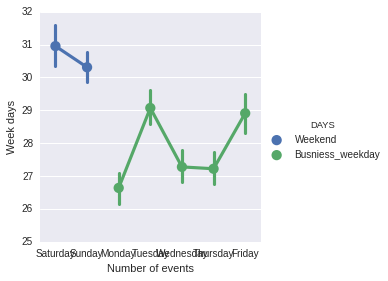

In [12]:

sns.set_context(rc={"figure.figsize": (15, 13)})

ax=sns.factorplot(x="day_of_week", y="ts_y", hue="DAYS", data=Counts_annon);
ax.set(xlabel='Number of events', ylabel='Week days')


101290

Adding the features

In [53]:
TA_log.ts = pd.to_datetime(TA_log.ts)

TA_log['date'] = TA_log.ts.dt.floor('d')

u = TA_log.uuid.unique()
a = TA_log.groupby(['uuid', 'date']).size().reset_index(level=1, drop=True)
a = a[a>5]
New = a[~a.index.duplicated()].astype(bool).reindex(u, fill_value=False).to_frame(name='Highly_Active')

a = TA_log.groupby('uuid')['ts'].nunique()
New['Multiple_days'] = a[a>5].astype(bool).reindex(u, fill_value=False)

a = TA_log[(TA_log.Busi_days==True)&(TA_log.Busi_hours==True)].uuid.unique()
New['Busi_weekday'] = New.index.isin(a)
New.reset_index(inplace=True)

In [226]:
def func(df):
    df.ts = pd.to_datetime(df.ts)

    df['date'] = df.ts.dt.floor('d')

    u = df.uuid.unique()
    a = df.groupby(['uuid', 'date']).size().reset_index(level=1, drop=True)
    a = a[a>1]
    target_df = (a[~a.index.duplicated()]
                    .astype(bool).reindex(u, fill_value=False).to_frame(name='Active'))

    a = df.groupby('uuid')['ts'].nunique()
    target_df['Multiple_days'] = a[a>1].astype(bool).reindex(u, fill_value=False)

    a = df.loc[(df.Busi_days==True)&(df.Busi_hours==True)].uuid.unique()
    target_df['Busi_weekday'] = target_df.index.isin(a)
    return target_df

##Logististic Regression for fourth feature

In [228]:
Count_ann_new=pd.merge(New,Counts_annon[["ts_y","uuid"]],on='uuid')
Count_ann_new.columns[4:]


Index(['ts_y'], dtype='object')

In [182]:
import statsmodels.api as sm

train_cols = Count_ann_new.columns[4:]
logit = sm.Logit(Count_ann_new['Highly_Active'], Count_ann_new['ts_y'])
result = logit.fit()
coeff = result.params

# fit the model
print (result.summary()) #result has more information
Count_ann_new['My_feature'] = result.predict()
Count_ann_new.head()

Optimization terminated successfully.
         Current function value: 0.572365
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Highly_Active   No. Observations:               669491
Model:                          Logit   Df Residuals:                   669490
Method:                           MLE   Df Model:                            0
Date:                Fri, 26 Jan 2018   Pseudo R-squ.:                  0.1479
Time:                        15:09:21   Log-Likelihood:            -3.8319e+05
converged:                       True   LL-Null:                   -4.4973e+05
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ts_y           0.0525      0.000    244.574      0.000         0.052     0.053


,uuid,Highly_Active,Multiple_days,Busi_weekday,ts_y,My_feature
0,313908E1F6825D28ADF3FCE451E5B5E5,False,False,True,3,0.539278
1,313908E1F6825D28ADF3FCE451E5B5E5,False,False,True,3,0.539278
2,313908E1F6825D28ADF3FCE451E5B5E5,False,False,True,3,0.539278
3,C7F60E6140A59120D9C9854CA87758DF,False,False,False,1,0.513117
4,2DC20DA3585AEDFD846E8679AE5C14C7,True,True,True,8,0.603443


In [183]:
Count_ann_new.query('My_feature ==1').shape ## When HA

(1804, 6)

In [179]:
Count_ann_new.query('My_feature ==1').shape ## When MD

(12705, 7)

In [49]:
Counts_annon.std()

Busi_days      0.458661
Busi_hours     0.498866
ts_y          81.145601
dtype: float64

In [12]:
New_melt=pd.melt(New,id_vars='uuid')
New_melt['Activity']=New_melt['variable'].mask(~New_melt['value'], 'NO')

New_melt_new=New_melt.query('Activity !="NO"')
New_melt_new_annon=pd.merge(New_melt_new[["Activity","uuid"]],Counts_annon,on='uuid')
New_melt_new_annon.head()

,Activity,uuid,ts_x,useragent,hashed_ip,day_of_week,date,Busi_days,Busi_hours,DAYS,ts_y
0,Highly_Active,2DC20DA3585AEDFD846E8679AE5C14C7,2017-07-11 11:29:40,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,4F32D980A86D,Tuesday,2017-07-11,True,True,Busniess_weekday,8
1,Highly_Active,2DC20DA3585AEDFD846E8679AE5C14C7,2017-07-11 11:29:43,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,4F32D980A86D,Tuesday,2017-07-11,True,True,Busniess_weekday,8
2,Highly_Active,2DC20DA3585AEDFD846E8679AE5C14C7,2017-07-29 15:00:42,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,0147187294E3,Saturday,2017-07-29,False,True,Weekend,8
3,Highly_Active,2DC20DA3585AEDFD846E8679AE5C14C7,2017-07-29 15:02:14,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,0147187294E3,Saturday,2017-07-29,False,True,Weekend,8
4,Highly_Active,2DC20DA3585AEDFD846E8679AE5C14C7,2017-07-29 15:03:26,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,0147187294E3,Saturday,2017-07-29,False,True,Weekend,8


/home/alva/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


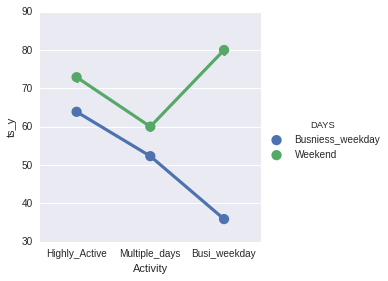

In [68]:
import matplotlib.dates as mdates

import seaborn as sns

sns.set(rc={'figure.figsize':(15,5)})
sns.factorplot(x='Activity', y='ts_y', hue="DAYS", data=New_melt_new_annon);


In [54]:
Week_busi=TA_log[['DAYS','uuid','ts']].groupby(['uuid','DAYS']).count()
Week_busi.reset_index(inplace=True)
Week_busi_annon=pd.merge(Week_busi[["uuid","ts"]],TA_log,on='uuid')
Week_busi_annon.head()

,uuid,ts_x,ts_y,useragent,hashed_ip,day_of_week,date,Busi_days,Busi_hours,DAYS
0,0000AE02C6B52538D17DFAF66F2ACAF1,1,2017-07-26 23:41:34,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5)...,FD16201EBBBE,Wednesday,2017-07-26,True,False,Busniess_weekday
1,0000CD03517160EAEDB23A93A16489AE,1,2017-07-23 14:24:34,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:54.0) G...,973F5B6D32ED,Sunday,2017-07-23,False,True,Weekend
2,0000F516516CD22AC34384D65FE369B6,4,2017-07-26 21:20:45,Mozilla/5.0 (Linux; Android 6.0.1; D5803 Build...,26FB5945C6EA,Wednesday,2017-07-26,True,False,Busniess_weekday
3,0000F516516CD22AC34384D65FE369B6,4,2017-07-26 21:23:23,Mozilla/5.0 (Linux; Android 6.0.1; D5803 Build...,26FB5945C6EA,Wednesday,2017-07-26,True,False,Busniess_weekday
4,0000F516516CD22AC34384D65FE369B6,4,2017-07-26 21:12:51,Mozilla/5.0 (Linux; Android 6.0.1; D5803 Build...,26FB5945C6EA,Wednesday,2017-07-26,True,False,Busniess_weekday


In [64]:
##Distributions of three features across the month

In [62]:
##Distributtaion in Highlyactive feature

/home/alva/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:20: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
/home/alva/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:23: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


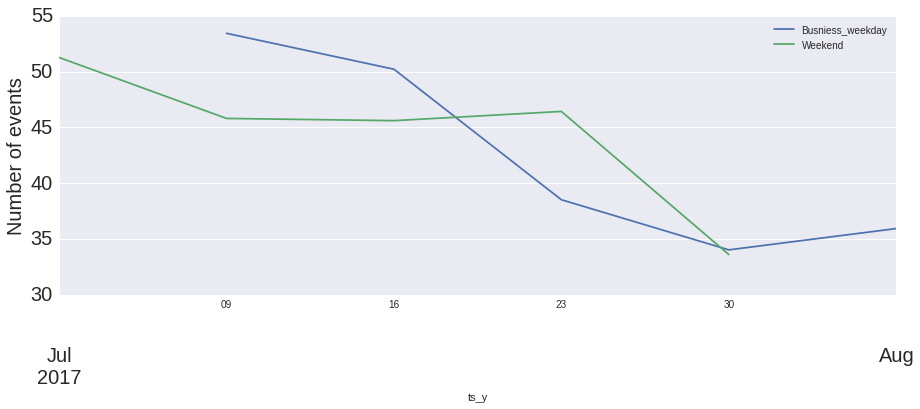

In [63]:
Week_busi=TA_log[['DAYS','uuid','ts']].groupby(['uuid','DAYS']).count()
Week_busi.reset_index(inplace=True)
Week_busi_annon=pd.merge(Week_busi[["uuid","ts"]],TA_log,on='uuid')
High_week_busi=Week_busi_annon.query('ts_x>5')
Week_busi_annon.ts_x.max()
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.set_ylabel('Number of events', fontsize = 20.0)
plt.xticks(size = 20)
plt.yticks(size = 20)
import seaborn as sns

sns.set(rc={'figure.figsize':(15,5)})
for TA in High_week_busi.DAYS.unique():
    TA_df = High_week_busi.loc[High_week_busi.DAYS == TA]
    TA_df.index = TA_df['ts_y']
    TA_df = TA_df.resample('1W')
    TA_df.plot(x=TA_df.index,
                     y='ts_x', 
                     ax=ax,
                     label=TA)
    

#plt.savefig('Groups.png')
plt.show()

(14320, 8)